## Variable类和Function类以及back propegarion的实现
反向传播复习：[李宏毅2021](https://www.bilibili.com/video/BV1Wv411h7kN?p=14&vd_source=0d567fd8ba32ba934dec5ee477e4de17)

b站讲解视频P10

当我们在用反向传播计算损失函数对模型中所有参数的导数时，我们需要从后往前依次计算导数。

如何维护计算导数的顺序呢？

代码中运用了generation来维护，

Function对象和Variable对象都有generation参数，保证某个函数的generation一定大于其输入变量，小于其输出变量。

再根据generation来维护funcs列表中各个函数对象的顺序，从而使得反向传播时导数计算正确

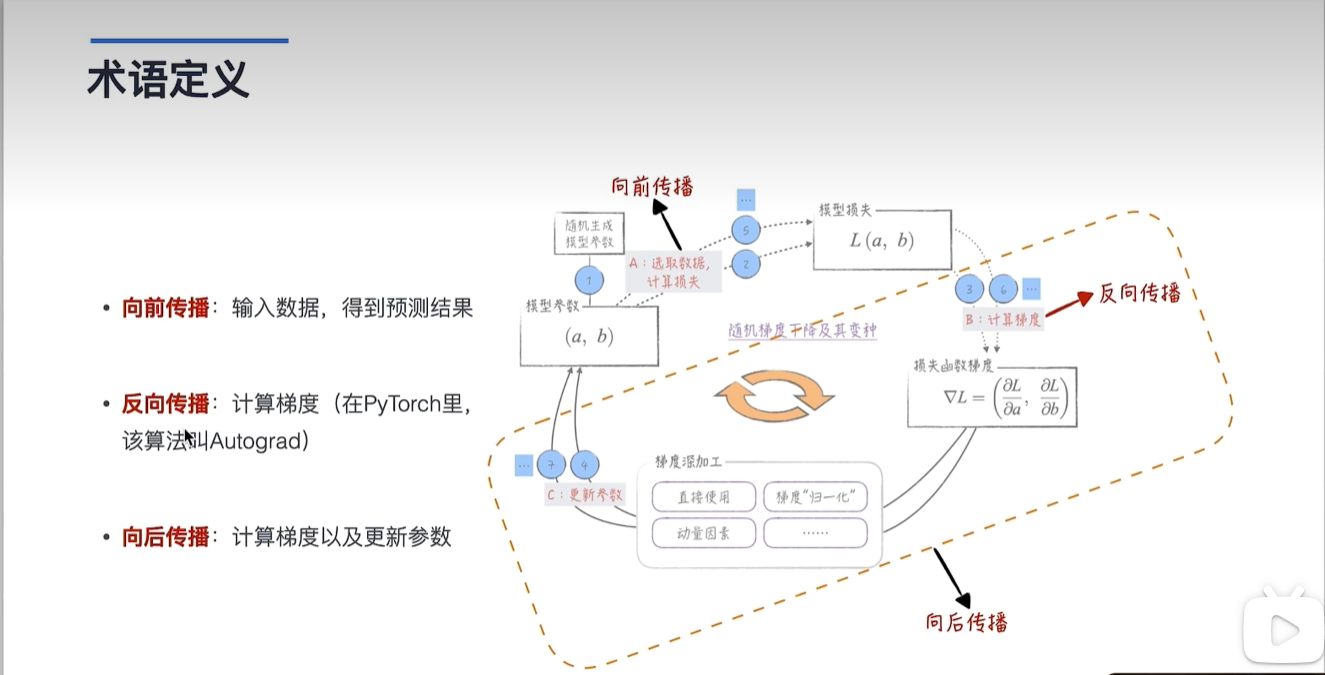

如果看完代码注释还是不是很理解的话，可以自己画一个两三层的小网络，然后把forward和backword的过程自己顺一遍。

In [ ]:
class Variable: #对应着pytorch里的tensor
    __array_priority__ = 200

    def __init__(self, data: np.ndarray, name=None):
        if data is not None:
            if not isinstance(data, array_types):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # 储存该变量的值
        self.grad = None # 储存该变量的导数
        self.creator = None # 记录产生该变量的Function对象
        self.name = name
        self.generation = 0 #用来记录该变量实在计算图中的第几个操作生成的

    def set_creator(self, func: "Function"):
        self.creator: "Function" = func
        self.generation = func.generation + 1 # 保证函数的generation小于该函数输出值的generation

    def backward(self, retain_grad: bool = False, create_graph=False):
        from cuda import get_array_module
        if self.grad is None: # 如果这个变量还没有导数说明是顶点，则其对于自身的导数是1
            xp = get_array_module(self.data)
            self.grad = Variable(xp.ones_like(self.data))

        funcs: list[Function] = []
        seen_set: set[Function] = set() # 储存已经遍历过的函数对象

        # 某一个variable对象大概率是多个函数输出的和
        # 当这个variable对象的creator被调用时，就会将这个函数添加到funcs中
        def add_func(f): 
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f: "Function" = funcs.pop()
            xs = f.inputs
            gys = [output().grad for output in f.outputs]
            # 这里的output()会返回被引用的原始对象
            with using_config('enable_backprop', create_graph):
                gxs = f.backward(*gys) # 上一层参数的导数
                if not isinstance(gxs, tuple): # 如果gxs不是tuple类型
                    gxs = (gxs,) # 将gxs变为tuple类型

                for x, gx in zip(xs, gxs): # zip函数将xs和gxs中的元素一一对应，生成一个新的迭代器
                    if x.grad is not None: # 每次返回一个元组(x, gx)
                        x.grad = x.grad + gx # 更新上一层变量
                    else:
                        x.grad = gx

                    if x.creator is not None:
                        add_func(x.creator) # 将上一层变量的creator添加进待处理函数列表
                if not retain_grad:    
                    for y in f.outputs:
                        y().grad = None

    def cleargrad(self):
        self.grad = None

    def to_cpu(self):
        from cuda import as_numpy
        if self.data is not None:
            self.data = as_numpy(self.data)

    def to_gpu(self):
        from cuda import as_cupy
        if self.data is not None:
            self.data = as_cupy(self.data)

    @property
    def shape(self):
        return self.data.shape

    @property
    def size(self):
        return self.data.size

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'Variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'Variable(' + p + ')'

    def __add__(self, other):
        from functions import add
        return add(self, other)

    def __radd__(self, other):
        from functions import add
        return add(self, other)

    def __mul__(self, other):
        from functions import mul
        return mul(self, other)

    def __rmul__(self, other):
        from functions import mul
        return mul(self, other)

    def __neg__(self):
        from functions import neg
        return neg(self)

    def __sub__(self, other):
        from functions import sub
        return sub(self, other)

    def __rsub__(self, other):
        from functions import rsub
        return rsub(self, other)

    def __truediv__(self, other):
        from functions import div
        return div(self, other)

    def __rtruediv__(self, other):
        from functions import rdiv
        return rdiv(self, other)

    def __pow__(self, power, modulo=None):
        from functions import pow
        return pow(self, power)

    def __getitem__(self, item):
        from functions import get_item
        return get_item(self, item)

    def reshape(self, *shape):
        from functions import reshape
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return reshape(self, shape)

    def transpose(self, *axes):
        from functions import transpose
        if len(axes) == 0:
            axes = None
        elif len(axes) == 1:
            if isinstance(axes[0], (tuple, list)) or axes[0] is None:
                axes = axes[0]
        return transpose(self, axes)

    @property
    def T(self):
        from functions import transpose
        return transpose(self)

    def sum(self, axis=None, keepdims=False):
        from functions import sum
        return sum(self, axis=axis, keepdims=keepdims)


class Parameter(Variable):
    pass